<a href="https://colab.research.google.com/github/desstaw/Shortcut_Learning/blob/main/SAE_birds_left_patch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import numpy as np
import torch
from torch import nn, optim
from torchvision import models, transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import matplotlib.pyplot as plt
import gc
from scipy.stats import pearsonr

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
# Step 1: Preprocess images, extract or load activations

class ImageDataset(Dataset):
    def __init__(self, image_paths, transform=None):
        print(f"Initializing dataset with {len(image_paths)} images")
        self.image_paths = image_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        print(f"Loading image: {image_path}")
        image = Image.open(image_path)
        if self.transform:
            image = self.transform(image)
        return image

def load_model(model_path):
    print(f"Loading model from {model_path}")
    model = models.alexnet(weights=None)
    model.classifier[-1] = torch.nn.Linear(4096, 2)
    model.load_state_dict(torch.load(model_path))
    model.to(device)
    model.eval()
    print("Model loaded successfully")
    return model



preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

def preprocess_and_extract_activations(model, dataloader, layer):
    activations = []
    with torch.no_grad():
        for batch_idx, image_tensor in enumerate(dataloader):
            print(f"Processing batch {batch_idx + 1}/{len(dataloader)}")
            image_tensor = image_tensor.to(device)

            if layer < 13:  # Layer in model.features
                tensor = image_tensor
                for idx, layer_module in enumerate(model.features[:layer + 1]):
                    tensor = layer_module(tensor)
            else:  # Layer in model.classifier
                tensor = model.features(image_tensor)
                tensor = model.avgpool(tensor)
                tensor = torch.flatten(tensor, 1)
                for idx, layer_module in enumerate(model.classifier[:layer - 12]):
                    tensor = layer_module(tensor)

            activation = tensor.cpu().numpy()
            activations.append(activation)

    print(f"Extracted activations for layer {layer}, total activations: {len(activations)}")
    return activations

def process_images_in_folder(model, folder_path, layer, batch_size=10):
    print(f"Processing images in folder: {folder_path} for layer {layer}")
    image_paths = [os.path.join(root, file)
                   for root, dirs, files in os.walk(folder_path)
                   for file in files if file.endswith(('.jpg', '.png'))]

    print(f"Found {len(image_paths)} images")
    dataset = ImageDataset(image_paths, transform=preprocess)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

    activations = preprocess_and_extract_activations(model, dataloader, layer)
    torch.cuda.empty_cache()
    gc.collect()

    return activations

def flatten_and_align_activations(activations_list):
    print("Flattening and aligning activations")
    flat_activations = [act.flatten() for act in activations_list]
    max_length = max(len(act) for act in flat_activations)

    aligned_activations = []
    for activation in flat_activations:
        if len(activation) < max_length:
            padded_activation = np.pad(activation, (0, max_length - len(activation)), 'constant')
        else:
            padded_activation = activation[:max_length]
        aligned_activations.append(padded_activation)
    print(f"Aligned activations to shape: {np.vstack(aligned_activations).shape}")
    return np.vstack(aligned_activations)

def save_activations(activations, folder_name, filename):
    drive_path = f'/content/drive/MyDrive/Masterthesis/Datasets/CUB/activations_balanced/{folder_name}/{filename}.npy'
    os.makedirs(os.path.dirname(drive_path), exist_ok=True)
    print(f"Saving activations to {drive_path}")
    np.save(drive_path, activations)

def load_activations(folder_name, filename):
    drive_path = f'/content/drive/MyDrive/Masterthesis/Datasets/CUB/activations_balanced/{folder_name}/{filename}.npy'
    print(f"Loading activations from {drive_path}")
    return np.load(drive_path, allow_pickle=True)

def compute_activations_for_layers(model_paths, folder_paths, layers, activations_file_prefix):
    all_layer_activations = {layer: [] for layer in layers}

    for model_idx, model_path in enumerate(model_paths):
        print(f"Processing model {model_idx + 1}/{len(model_paths)}")
        model = load_model(model_path)

        for folder_name, folder_path in folder_paths.items():
            print(f"Processing folder {folder_name}")

            for layer in layers:
                # Check if activations already exist
                activation_path = f'/content/drive/MyDrive/Masterthesis/Datasets/CUB/activations_balanced/model_{model_idx}/layer_{layer}/{activations_file_prefix}_{folder_name}.npy'

                if os.path.exists(activation_path):
                    print(f"Activations for model {model_idx}, layer {layer}, folder {folder_name} already exist. Loading from file.")
                    activations = load_activations(f'model_{model_idx}/layer_{layer}', f'{activations_file_prefix}_{folder_name}')

                    # Check if loaded activations are empty
                    if activations.size == 0:
                        print(f"Warning: Loaded activations for model {model_idx}, layer {layer}, folder {folder_name} are empty!")
                    else:
                        print(f"Loaded activations shape: {activations.shape}")
                else:
                    print(f"Computing activations for model {model_idx}, layer {layer}, folder {folder_name}.")
                    activations = process_images_in_folder(model, folder_path, layer)
                    activations = flatten_and_align_activations(activations)
                    save_activations(activations, f'model_{model_idx}/layer_{layer}', f'{activations_file_prefix}_{folder_name}')

                all_layer_activations[layer].append(activations)

        del model
        torch.cuda.empty_cache()
        gc.collect()

    return all_layer_activations


# Step 2: Extract Training Activations

model_paths = [
    "/content/drive/MyDrive/Masterthesis/Datasets/CUB/models/initial_classifier/alexnet_places_wb_balanced_dist_1train.pt",
    "/content/drive/MyDrive/Masterthesis/Datasets/CUB/models/initial_classifier/alexnet_places_wb_balanced_dist_11train.pt",
    "/content/drive/MyDrive/Masterthesis/Datasets/CUB/models/initial_classifier/alexnet_places_wb_balanced_dist_111train.pt"
]

layers_of_interest = [0, 3, 6, 8, 10, 14, 17]

# Paths to training data
folder_paths = {
    'wb_no_patch': '/content/drive/MyDrive/Masterthesis/Datasets/CUB/cub_balanced/train/wb_no_patch',
    'lb_no_patch': '/content/drive/MyDrive/Masterthesis/Datasets/CUB/cub_balanced/train/lb_no_patch',
    'lb_patch': '/content/drive/MyDrive/Masterthesis/Datasets/CUB/cub_balanced/train/lb_patch'
}

# Extract and save training activations
train_activations = compute_activations_for_layers(model_paths, folder_paths, layers_of_interest, 'train')


Processing model 1/3
Loading model from /content/drive/MyDrive/Masterthesis/Datasets/CUB/models/initial_classifier/alexnet_places_wb_balanced_dist_1train.pt


<ipython-input-3-f7c7e26d4fdb>:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


Model loaded successfully
Processing folder wb_no_patch
Activations for model 0, layer 0, folder wb_no_patch already exist. Loading from file.
Loading activations from /content/drive/MyDrive/Masterthesis/Datasets/CUB/activations_balanced/model_0/layer_0/train_wb_no_patch.npy
Loaded activations shape: (237, 1936000)
Activations for model 0, layer 3, folder wb_no_patch already exist. Loading from file.
Loading activations from /content/drive/MyDrive/Masterthesis/Datasets/CUB/activations_balanced/model_0/layer_3/train_wb_no_patch.npy
Loaded activations shape: (237, 1399680)
Activations for model 0, layer 6, folder wb_no_patch already exist. Loading from file.
Loading activations from /content/drive/MyDrive/Masterthesis/Datasets/CUB/activations_balanced/model_0/layer_6/train_wb_no_patch.npy
Loaded activations shape: (237, 648960)
Activations for model 0, layer 8, folder wb_no_patch already exist. Loading from file.
Loading activations from /content/drive/MyDrive/Masterthesis/Datasets/CUB/a

Define Sparse Autoencoder

In [ ]:
import torch
from torch.utils.data import DataLoader, TensorDataset
import numpy as np

# Step 3: Define Sparse Autoencoder Function

class SparseAutoencoder(nn.Module):
    def __init__(self, input_dim, encoding_dim):
        super(SparseAutoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, encoding_dim),
            nn.BatchNorm1d(encoding_dim),
            nn.ReLU(True)
        )
        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, input_dim),
            nn.Sigmoid()  # Only use if the data is normalized to [0, 1]
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded

class EarlyStopping:
    def __init__(self, patience=10, min_delta=0.01):
        self.patience = patience
        self.min_delta = min_delta
        self.best_loss = None
        self.counter = 0

    def check(self, loss):
        if self.best_loss is None:
            self.best_loss = loss
            return False

        if loss < self.best_loss - self.min_delta:
            self.best_loss = loss
            self.counter = 0
            return False
        else:
            self.counter += 1
            if self.counter >= self.patience:
                print("Early stopping triggered.")
                return True
        return False

def normalize_activations(activations):
    """
    Normalize activations to have zero mean and unit variance.
    """
    activations -= np.mean(activations, axis=0)
    activations /= np.std(activations, axis=0)
    return activations

def train_autoencoder(autoencoder, data, num_epochs=50, batch_size=32, learning_rate=1e-3, validation_split=0.1):
    print(f"Training autoencoder with input dim {data.shape[1]} and encoding dim {autoencoder.encoder[0].out_features}")

    # Split data into training and validation sets
    num_train = int((1 - validation_split) * len(data))
    train_data = data[:num_train]
    val_data = data[num_train:]

    train_dataset = torch.utils.data.TensorDataset(torch.from_numpy(train_data))
    val_dataset = torch.utils.data.TensorDataset(torch.from_numpy(val_data))

    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(autoencoder.parameters(), lr=learning_rate, weight_decay=1e-5)
    early_stopping = EarlyStopping(patience=5, min_delta=0.001)

    autoencoder.train()
    for epoch in range(num_epochs):
        total_train_loss = 0
        for x_batch, in train_loader:
            x_batch = x_batch.to(device).float()
            optimizer.zero_grad()
            _, decoded = autoencoder(x_batch)
            loss = criterion(decoded, x_batch)
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()

        total_val_loss = 0
        autoencoder.eval()
        with torch.no_grad():
            for x_batch, in val_loader:
                x_batch = x_batch.to(device).float()
                _, decoded = autoencoder(x_batch)
                loss = criterion(decoded, x_batch)
                total_val_loss += loss.item()

        print(f'Epoch {epoch + 1}/{num_epochs}, Train Loss: {total_train_loss / len(train_loader)}, Val Loss: {total_val_loss / len(val_loader)}')

        if early_stopping.check(total_val_loss / len(val_loader)):
            break

    print("Autoencoder training completed")
    return autoencoder

# Step 4: Train Sparse Autoencoder on Each Layer's Activations

encoding_dim = 128  # Dimension of the sparse space
autoencoders = {}

for layer in layers_of_interest:
    print(f'Training autoencoder for layer {layer}')
    input_dim = train_activations[layer][0].shape[1]
    autoencoder = SparseAutoencoder(input_dim, encoding_dim).to(device)

    # Normalize activations
    normalized_activations = normalize_activations(np.vstack(train_activations[layer]))

    if layer in [3, 6]:  # Example: Adjust learning rate or epochs for certain layers
        autoencoder = train_autoencoder(autoencoder, normalized_activations, num_epochs=50, learning_rate=1e-3)
    else:
        autoencoder = train_autoencoder(autoencoder, normalized_activations, num_epochs=50, learning_rate=1e-3)

    # Save the trained autoencoder
    torch.save(autoencoder.state_dict(), f'autoencoder_layer_{layer}.pth')

    autoencoders[layer] = autoencoder

    # Clear the cache and free up memory
    del normalized_activations
    gc.collect()
    torch.cuda.empty_cache()

# Step 5: Project Test Activations into Sparse Space

def project_activations(autoencoder, activations):
    print(f"Projecting activations with shape {activations.shape} into sparse space")

    # Normalize activations before projection
    normalized_activations = normalize_activations(activations)

    autoencoder.eval()
    with torch.no_grad():
        projected = autoencoder.encoder(torch.from_numpy(normalized_activations).to(device).float())
    print(f"Projection completed with output shape {projected.shape}")
    return projected.cpu().numpy()

# Extract test activations
test_patch_folder_path = '/content/drive/MyDrive/Masterthesis/Datasets/CUB/cub_balanced/test/wb_patch'
test_no_patch_folder_path = '/content/drive/MyDrive/Masterthesis/Datasets/CUB/cub_balanced/test/wb_no_patch'

test_folder_paths = {
    'wb_patch': test_patch_folder_path,
    'wb_no_patch': test_no_patch_folder_path
}

# Extract test activations
print("Extracting test activations")
test_activations = compute_activations_for_layers(model_paths, test_folder_paths, layers_of_interest, 'test')

# Project test activations into sparse space
projected_test_activations = {}
projected_test_no_patch_activations = {}

for layer in layers_of_interest:
    print(f'Projecting activations for layer {layer}')
    autoencoder = autoencoders[layer]
    projected_test_activations[layer] = project_activations(autoencoder, np.vstack(test_activations[layer]))
    projected_test_no_patch_activations[layer] = project_activations(autoencoder, np.vstack(test_activations[layer]))

    # Clear GPU memory after each projection
    torch.cuda.empty_cache()

print("Projection of all test activations into sparse space completed.")

Training autoencoder for layer 0
Training autoencoder with input dim 1936000 and encoding dim 128
Epoch 1/50, Train Loss: 1.2106830477714539, Val Loss: 1.3123622179031371
Epoch 2/50, Train Loss: 1.0967066168785096, Val Loss: 1.2417388916015626
Epoch 3/50, Train Loss: 0.9319816306233406, Val Loss: 1.1259872198104859
Epoch 4/50, Train Loss: 0.8942182749509812, Val Loss: 1.0910418510437012
Epoch 5/50, Train Loss: 0.884966142475605, Val Loss: 1.080144715309143
Epoch 6/50, Train Loss: 0.8794806763529778, Val Loss: 1.0671455144882203
Epoch 7/50, Train Loss: 0.8764504879713059, Val Loss: 1.06588317155838
Epoch 8/50, Train Loss: 0.8739090219140053, Val Loss: 1.0603836178779602
Epoch 9/50, Train Loss: 0.8721122100949288, Val Loss: 1.0469944596290588
Epoch 10/50, Train Loss: 0.8690668910741806, Val Loss: 1.0492543935775758
Epoch 11/50, Train Loss: 0.8684907540678978, Val Loss: 1.0509872317314148
Epoch 12/50, Train Loss: 0.8664218693971634, Val Loss: 1.0412885665893554
Epoch 13/50, Train Loss: 0.

<ipython-input-3-f7c7e26d4fdb>:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


Model loaded successfully
Processing folder wb_patch
Activations for model 0, layer 0, folder wb_patch already exist. Loading from file.
Loading activations from /content/drive/MyDrive/Masterthesis/Datasets/CUB/activations_balanced/model_0/layer_0/test_wb_patch.npy
Loaded activations shape: (61, 1936000)
Activations for model 0, layer 3, folder wb_patch already exist. Loading from file.
Loading activations from /content/drive/MyDrive/Masterthesis/Datasets/CUB/activations_balanced/model_0/layer_3/test_wb_patch.npy
Loaded activations shape: (61, 1399680)
Activations for model 0, layer 6, folder wb_patch already exist. Loading from file.
Loading activations from /content/drive/MyDrive/Masterthesis/Datasets/CUB/activations_balanced/model_0/layer_6/test_wb_patch.npy
Loaded activations shape: (61, 648960)
Activations for model 0, layer 8, folder wb_patch already exist. Loading from file.
Loading activations from /content/drive/MyDrive/Masterthesis/Datasets/CUB/activations_balanced/model_0/la

<ipython-input-6-967a1114ec10>:24: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  A.append(pearsonr(patch_no_patch, combined_activations[:, ii])[0])


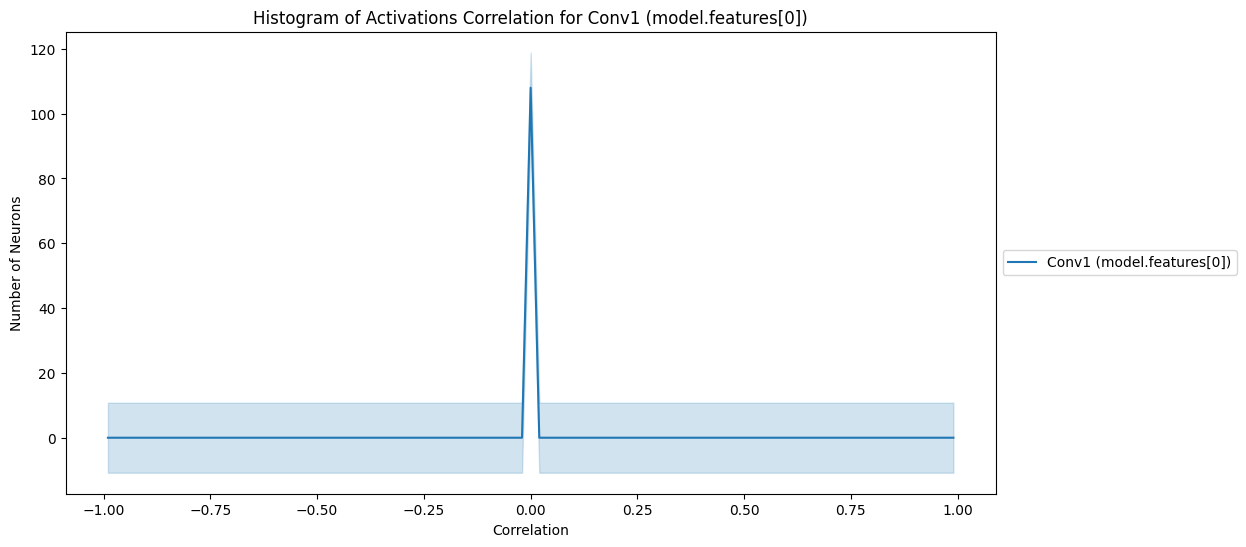

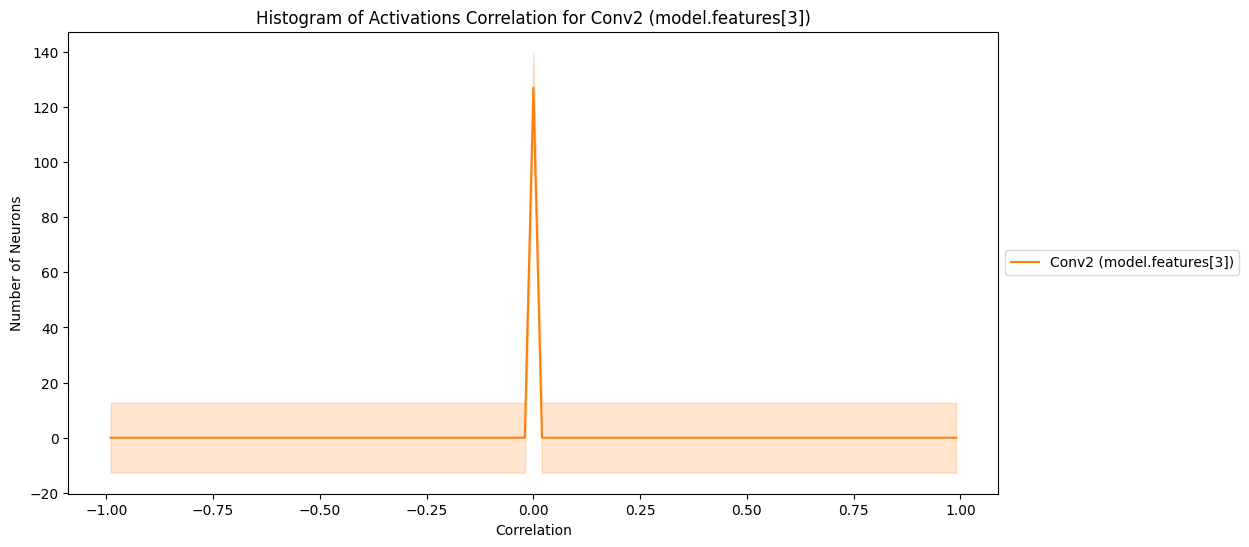

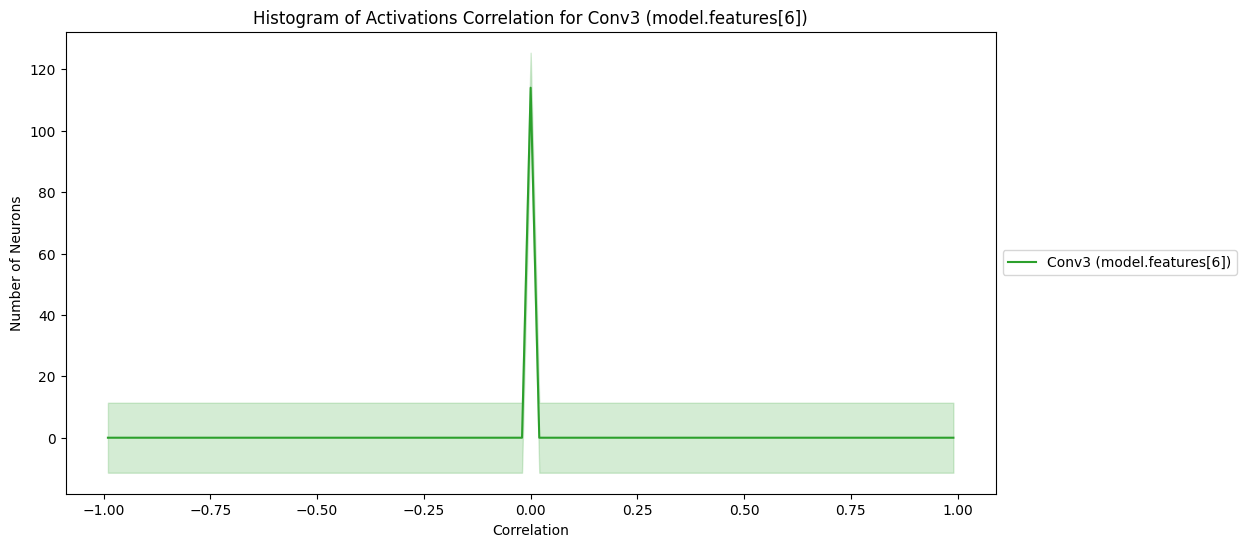

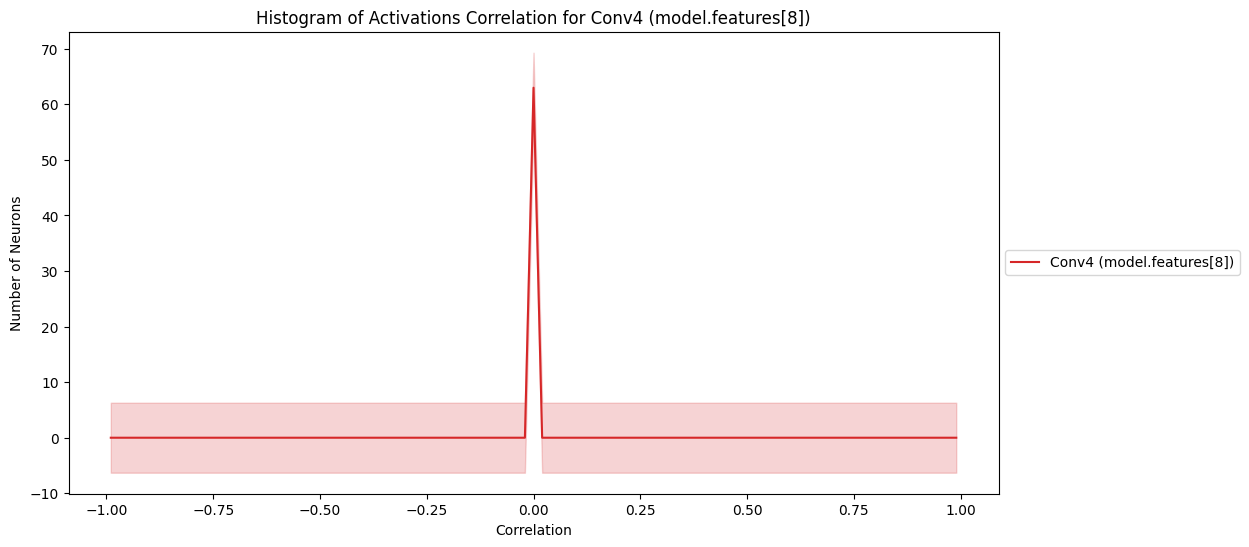

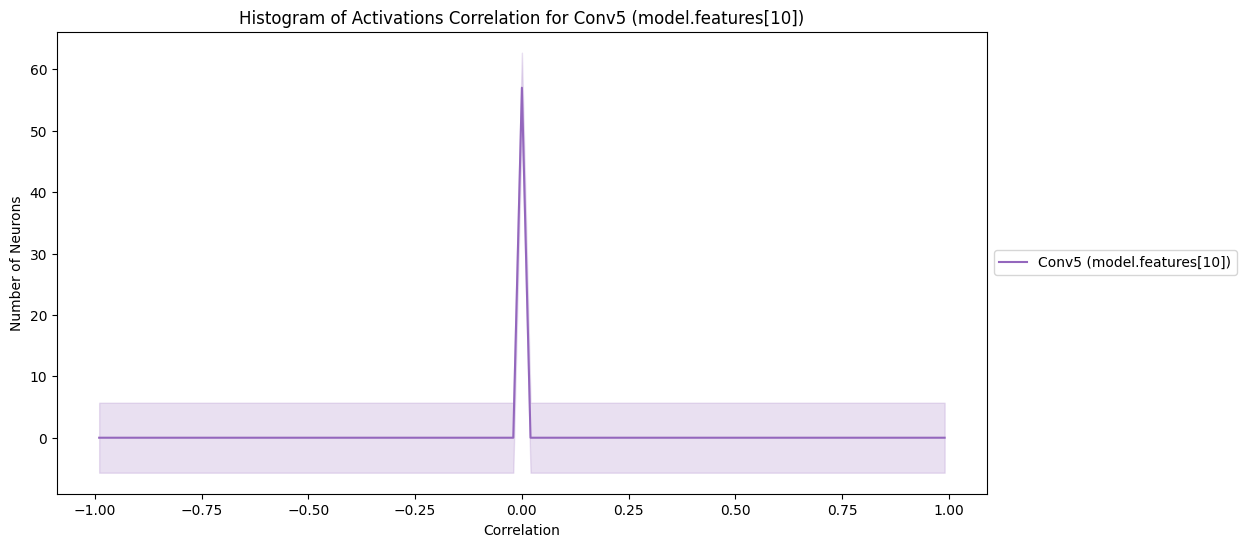

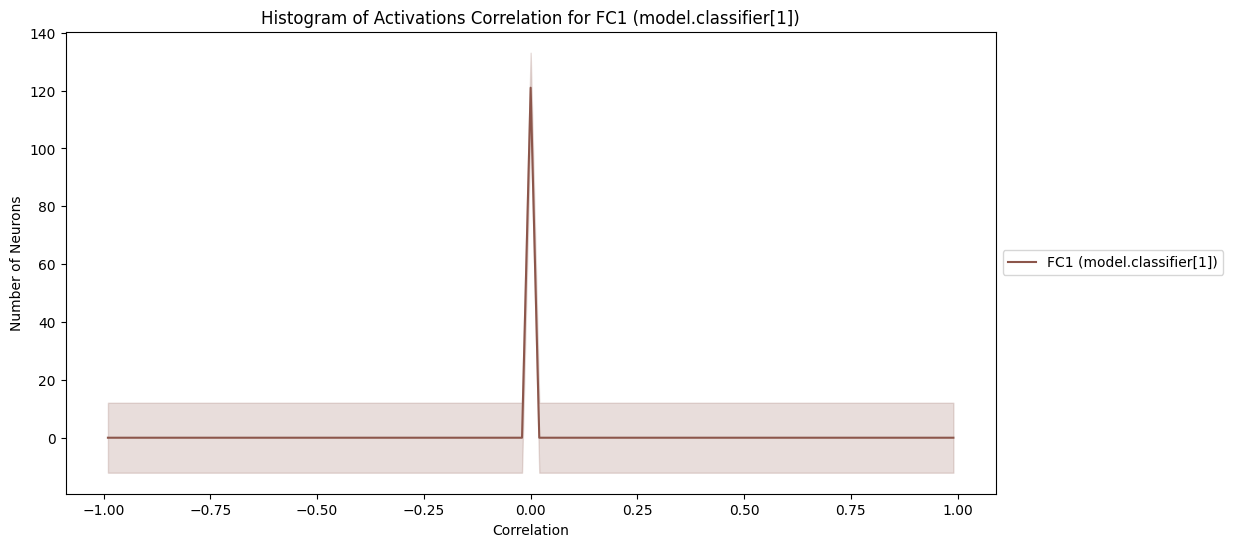

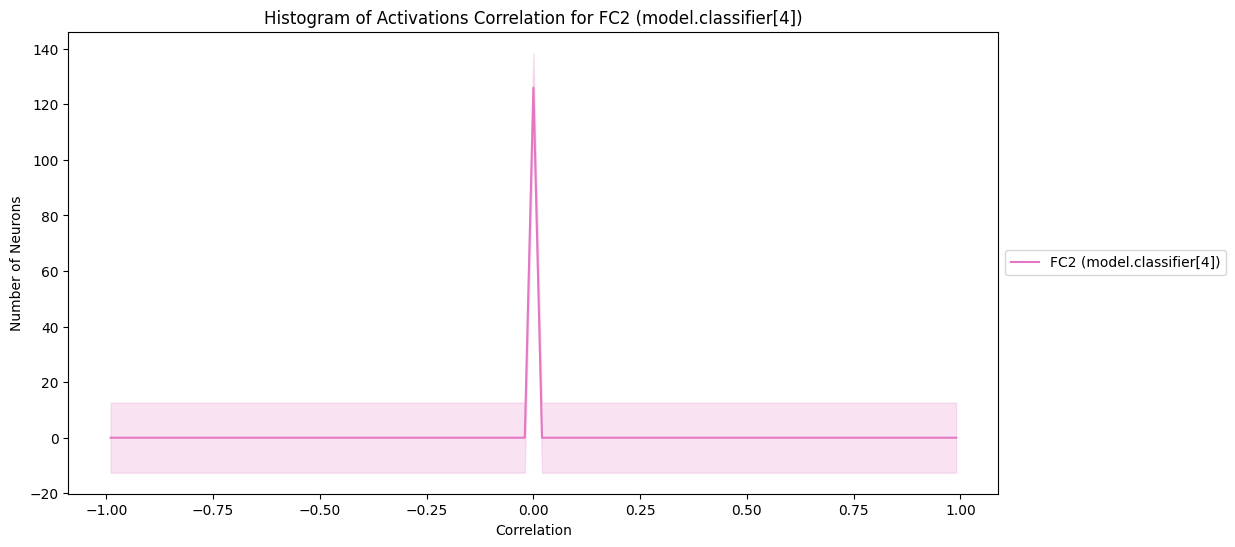

<ipython-input-6-967a1114ec10>:71: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  A.append(pearsonr(patch_no_patch, combined_activations[:, ii])[0])


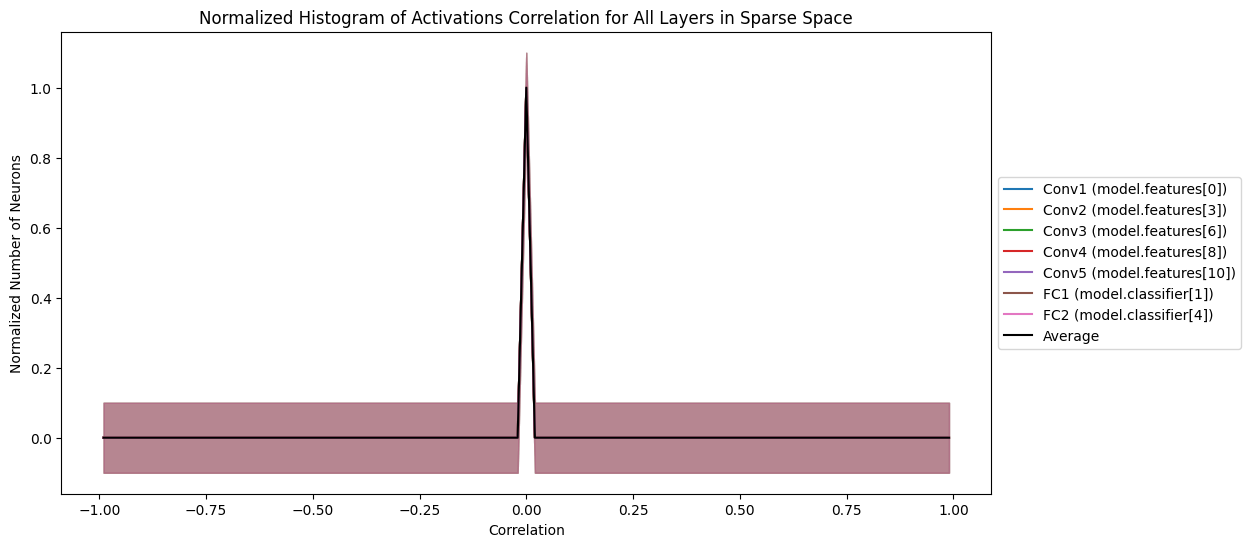

In [ ]:
# Step 6: Perform Correlation Analysis in Sparse Space
layer_names = {
    0: "Conv1 (model.features[0])",
    3: "Conv2 (model.features[3])",
    6: "Conv3 (model.features[6])",
    8: "Conv4 (model.features[8])",
    10: "Conv5 (model.features[10])",
    14: "FC1 (model.classifier[1])",
    17: "FC2 (model.classifier[4])"
}

colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink']

def plot_histogram_for_layer(layer, layer_name, activations_with_patch, activations_without_patch, color):
    x = np.linspace(start=-1, stop=1, num=100)
    xaxis = x + (x[1] - x[0]) / 2
    xaxis = xaxis[:-1]

    patch_no_patch = np.hstack([np.zeros(len(activations_without_patch)), np.ones(len(activations_with_patch))])
    combined_activations = np.vstack((activations_without_patch, activations_with_patch))

    A = []
    for ii in range(combined_activations.shape[1]):
        A.append(pearsonr(patch_no_patch, combined_activations[:, ii])[0])

    B = np.histogram(A, bins=x)

    bin_means = B[0]
    bin_stds = np.std(bin_means)

    fig = plt.figure(figsize=(12, 6))
    ax = fig.add_subplot(111)
    ax.plot(xaxis, bin_means, '-', color=color, label=layer_name)
    ax.fill_between(xaxis, bin_means - bin_stds, bin_means + bin_stds, color=color, alpha=0.2)
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.title(f'Histogram of Activations Correlation for {layer_name}')
    plt.xlabel('Correlation')
    plt.ylabel('Number of Neurons')
    plt.show()

# Perform the correlation analysis for each layer in the sparse space
for idx, layer in enumerate(layers_of_interest):
    plot_histogram_for_layer(
        layer,
        layer_names[layer],  # Use layer_names dictionary to get the name of the layer
        projected_test_activations[layer],
        projected_test_no_patch_activations[layer],
        colors[idx]  # Use colors list for the color
    )

# Combined Plot
def plot_combined_histogram(layer_names, colors, projected_test_activations, projected_test_no_patch_activations, layers_of_interest):
    fig = plt.figure(figsize=(12, 6))
    ax = fig.add_subplot(111)

    x = np.linspace(start=-1, stop=1, num=100)
    xaxis = x + (x[1] - x[0]) / 2
    xaxis = xaxis[:-1]

    all_layer_bin_means = []

    for idx, layer in enumerate(layers_of_interest):
        activations_with_patch = projected_test_activations[layer]
        activations_without_patch = projected_test_no_patch_activations[layer]

        patch_no_patch = np.hstack([np.zeros(len(activations_without_patch)), np.ones(len(activations_with_patch))])
        combined_activations = np.vstack((activations_without_patch, activations_with_patch))

        A = []
        for ii in range(combined_activations.shape[1]):
            A.append(pearsonr(patch_no_patch, combined_activations[:, ii])[0])

        B = np.histogram(A, bins=x)

        bin_means = B[0] / np.sum(B[0]) if np.sum(B[0]) != 0 else np.zeros_like(B[0])  # Normalize the bin counts, check for zero sum
        bin_stds = np.std(bin_means)

        all_layer_bin_means.append(bin_means)

        ax.plot(xaxis, bin_means, '-', color=colors[idx], label=layer_names[layer])
        ax.fill_between(xaxis, bin_means - bin_stds, bin_means + bin_stds, color=colors[idx], alpha=0.2)

    # Compute average and standard deviation of the normalized histograms across layers
    all_layer_bin_means = np.array(all_layer_bin_means)
    avg_bin_means = np.mean(all_layer_bin_means, axis=0)
    std_bin_means = np.std(all_layer_bin_means, axis=0)

    ax.plot(xaxis, avg_bin_means, '-', color='black', label='Average')
    ax.fill_between(xaxis, avg_bin_means - std_bin_means, avg_bin_means + std_bin_means, color='black', alpha=0.2)

    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.title('Normalized Histogram of Activations Correlation for All Layers in Sparse Space')
    plt.xlabel('Correlation')
    plt.ylabel('Normalized Number of Neurons')
    plt.show()

# Ensure layers_of_interest is passed correctly
plot_combined_histogram(layer_names, colors, projected_test_activations, projected_test_no_patch_activations, layers_of_interest)